# Machine Learning Fundamentals

In [1]:
import numpy as np
from numpy.random import default_rng
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Separating the State Space - The Hyperplane

### Visualising the State Space

In [2]:
# Define the boundaries of our state space
dim1_min, dim1_max = -15, 15
dim2_min, dim2_max = -15, 15

# Create a grid to sample the state space
resolution1, resolution2 = 31, 31

# We're using np.linspace to create evenly spaced points across our range. This gives us a systematic way to sample the state space rather than randomly picking points
dim1 = np.linspace(dim1_min, dim1_max, resolution1)
dim2 = np.linspace(dim2_min, dim2_max, resolution2)

print(f"Dimension 1 shape: {dim1.shape}, Dimension 2 shape: {dim2.shape}")

Dimension 1 shape: (31,), Dimension 2 shape: (31,)


In [3]:
dim1

array([-15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,
        -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.])

In [ ]:
# Create all possible coordinate combinations (our state space)
grid_1, grid_2 = np.meshgrid(dim1, dim2)

# Create coordinates directly from the meshgrid 
coords = np.c_[grid_1.ravel(), grid_2.ravel()]

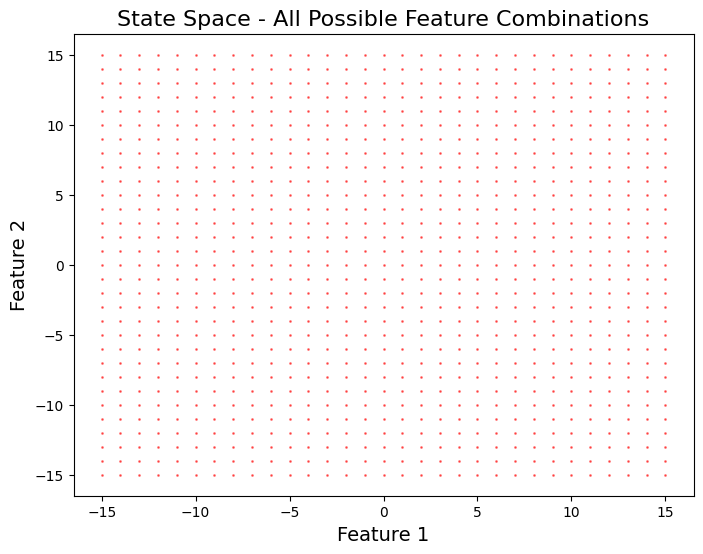

Total state space points: 961


In [5]:
fig, ax = subplots(figsize=(8, 6))
ax.scatter(coords[:,0], coords[:,1], c='red', s=1, alpha=0.5)
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_title('State Space - All Possible Feature Combinations', fontsize=16)
plt.show()

print(f"Total state space points: {coords.shape[0]}")

### Creating Training Data

Now let's create some sample data with two distinct classes:

In [50]:
# Set random seed for reproducibility
RANDOM_SEED_1 = 1234
rng = default_rng(RANDOM_SEED_1)

samples, features = 100, 2

# Parameters for two different classes
mean1, std1 = 0, 4
mean2, std2 = 5, 3

# Generate data for class 0
random_numbers1 = rng.normal(loc=mean1, scale=std1, size=(samples, features))
# Generate data for class 1
random_numbers2 = rng.normal(loc=mean2, scale=std2, size=(samples, features))

In [7]:
# Combine the data and create labels
X = np.vstack((random_numbers1, random_numbers2))
y = np.zeros(X.shape[0])

# Assign labels: first half = 0, second half = 1
y[X.shape[0]//2:] = 1

print(f"Data shape: {X.shape}")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Data shape: (200, 2)


In [8]:
X.shape[0]//2

100

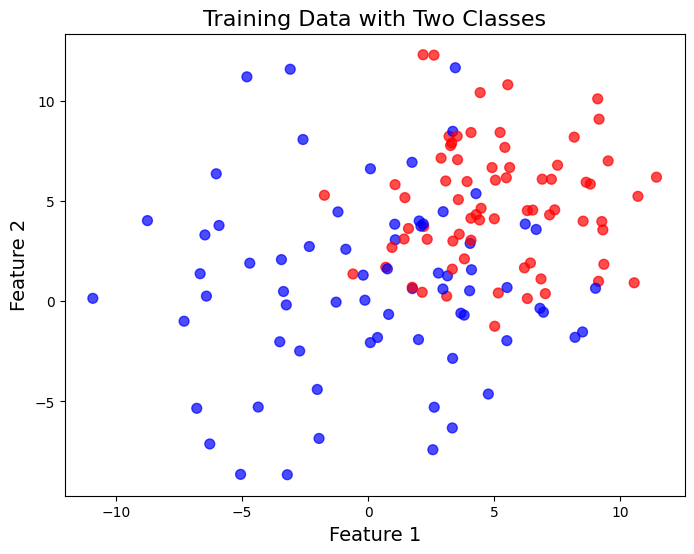

In [9]:
# Visualise the training data
fig, ax = subplots(figsize=(8, 6))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=50, alpha=0.7)
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_title('Training Data with Two Classes', fontsize=16)
plt.show()

We now have a state space to predict and then we have a sample of some of the population that is within this state space, our sample.

Our ML alogiorthm does not find the truth of the state space, it finds the best way to seperate your sample given this state space. We assume our sample is an accurate statistical representation of the whole population

## Support Vector Machines (SVMs)

## Random Forests

Random Forests use a completely different approach called **greedy tree-building**. Instead of finding one optimal boundary, they build many decision trees, each learning different patterns, then combine their predictions.

Each tree gets a sub-sample of the data and each split gets a random allocation of the features. This helps to not overfit to the data or have one feature dominate.

**The Maths Behind It:** Each tree uses the **Gini impurity** or **entropy** to decide splits: $Gini = 1 - \sum_{i} p_i^2$ where $p_i$ is the probability of class $i$.



In [10]:
# Train an SVM classifier
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

print(f"SVM Training Accuracy: {svm_clf.score(X_train, y_train):.3f}")
print(f"SVM Test Accuracy: {svm_clf.score(X_test, y_test):.3f}")

SVM Training Accuracy: 0.786
SVM Test Accuracy: 0.750


In [11]:
# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, y_train)

print(f"Random Forest Training Accuracy: {rf_clf.score(X_train, y_train):.3f}")
print(f"Random Forest Test Accuracy: {rf_clf.score(X_test, y_test):.3f}")

Random Forest Training Accuracy: 1.000
Random Forest Test Accuracy: 0.767


In [12]:
# Get probabilities for the grid
state_space_proba = svm_clf.predict_proba(coords)
proba_grid = state_space_proba[:, 1].reshape(grid_1.shape)

rf_state_space_proba = rf_clf.predict_proba(coords)
rf_proba_grid = rf_state_space_proba[:, 1].reshape(grid_1.shape)

## Understanding Model Confidence

The decision boundary is not always binary - a model can have uncertainty about the correctness of its prediction. Those closer to the boundary are typically less certain and will have lower probability for the dominant class. We can see the probability with `.predict_proba()`. Some classifiers don't have this unless explicitly computed at training time, which are then used later on.

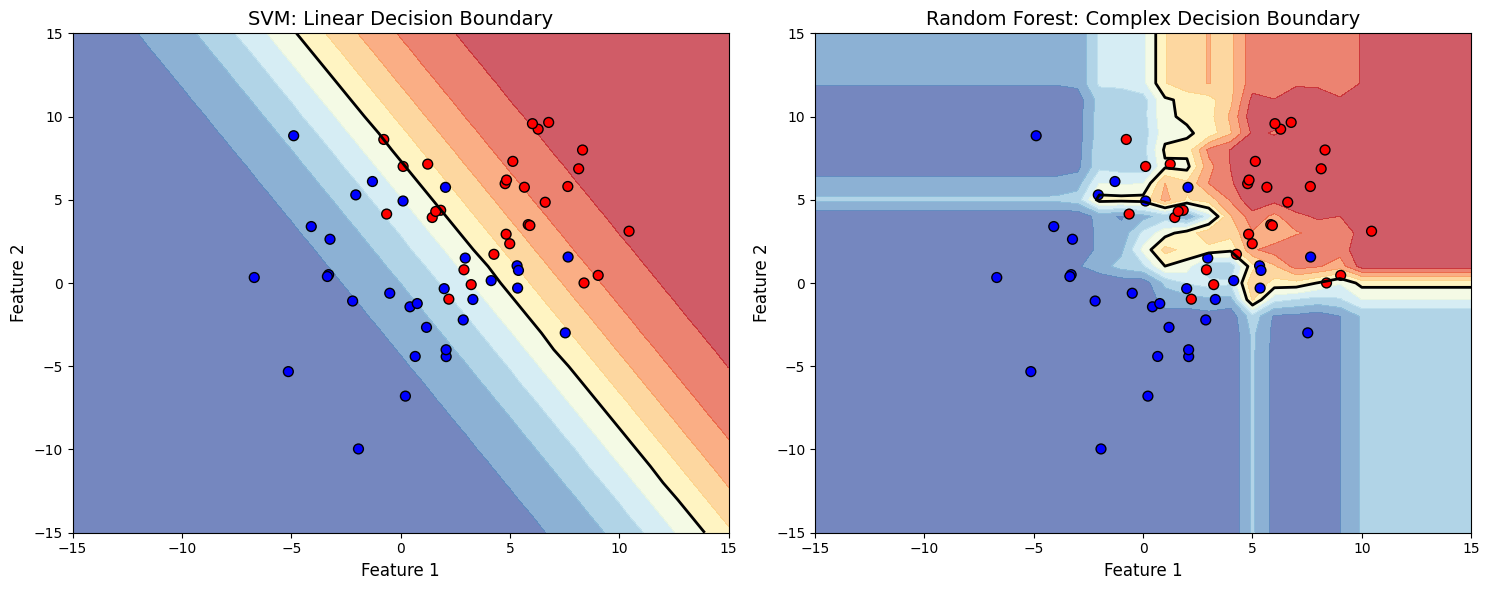

In [13]:
contour_levels = np.linspace(0, 1, 11)

fig, (ax1, ax2) = subplots(1, 2, figsize=(15, 6))

X_data, Y_data, target_data = X_test[:, 0], X_test[:, 1], y_test

# SVM boundary
cax1 = ax1.contourf(grid_1, grid_2, proba_grid, cmap='RdYlBu_r', levels=contour_levels, alpha=0.7)
ax1.contour(grid_1, grid_2, proba_grid, levels=[0.5], colors='black', linewidths=2)
ax1.scatter(X_data, Y_data, c=target_data, cmap='bwr', s=50, edgecolors='black')
ax1.set_title('SVM: Linear Decision Boundary', fontsize=14)
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)

# Random Forest boundary  
cax2 = ax2.contourf(grid_1, grid_2, rf_proba_grid, cmap='RdYlBu_r', levels=contour_levels, alpha=0.7)
ax2.contour(grid_1, grid_2, rf_proba_grid, levels=[0.5], colors='black', linewidths=2)
ax2.scatter(X_data, Y_data, c=target_data, cmap='bwr', s=50, edgecolors='black')
ax2.set_title('Random Forest: Complex Decision Boundary', fontsize=14)
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)

plt.tight_layout()
plt.show()